# Summary of KOI results

First, import stuff and read in data.  The KOI sample here is the CKS sample--stars that we have Keck/HIRES spectra for.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpld3

from gprot.summary import summarize_fits

mcq_df = pd.read_csv('../gprot/data/mcquillan_acf_kois.txt', comment='#')
mcq_df.index = mcq_df.koi_id
df = summarize_fits('../kois/results') # Requires data.
df.koi = pd.Series(df.index).apply(lambda s: int(s[4:]))
df.index = df.koi
print('Fit results of {} KOIs loaded.'.format(len(df)))

Fit results of 1067 KOIs loaded.


Next, let's check out the distribution of the median inferred hyperparameters of the set.  The thing that I note most is that $\ln G$ tends to sit a bit higher than for the Aigrain set, but things still look like they're in pretty good bunches.

/Users/tdm/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/tdm/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


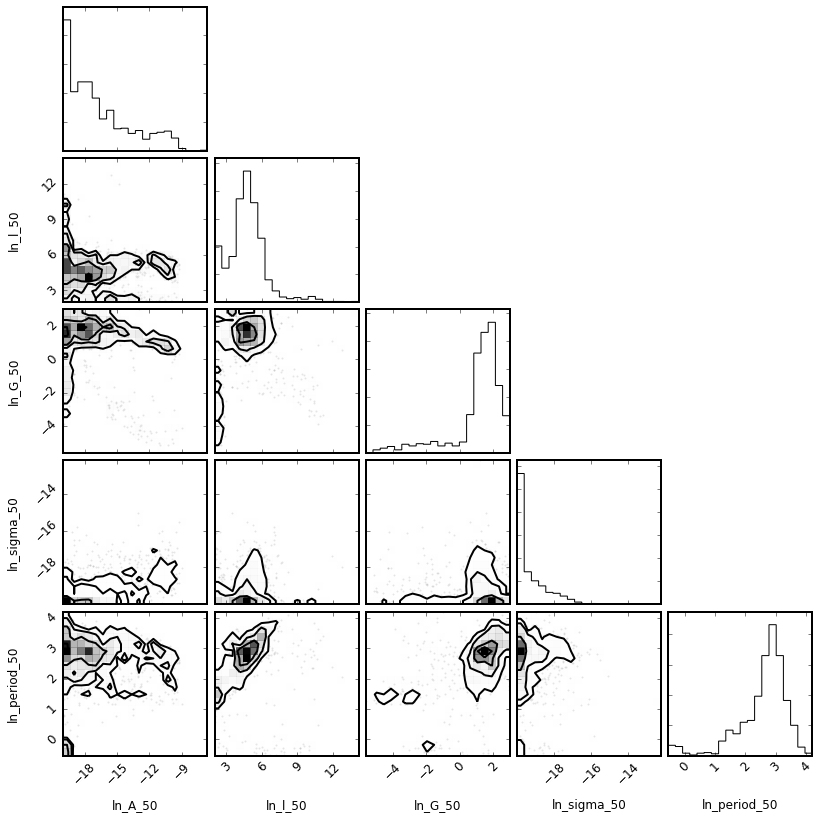

In [2]:
import corner
cols = ['ln_A_50', 'ln_l_50', 'ln_G_50', 'ln_sigma_50', 'ln_period_50']
mpld3.disable_notebook()
corner.corner(df[cols], labels=cols);

OK, now let's join our results with those from McQuillan+ (2013).  

In [3]:
subdf = df.ix[mcq_df.ix[df.koi].dropna().index].join(mcq_df) # is this using the right indices?
subdf['mcq_ln_period'] = np.log(subdf.P_rot)
subdf[['ln_period_16', 'ln_period_50', 'ln_period_84','mcq_ln_period']].head()
print('{} in common with McQ+13.'.format(len(subdf)))

266 in common with McQ+13.


Let's look at the comparison with the ACF results:

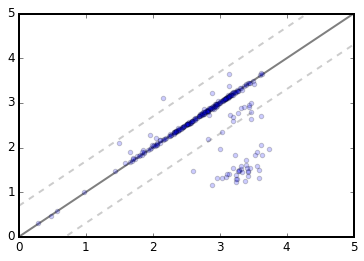

In [4]:
mpld3.enable_notebook()

def scatter_compare(df):
    fig, ax = plt.subplots(1,1)
    points = ax.scatter(df.mcq_ln_period, df.ln_period_50, alpha=0.2)
    ax.plot(range(6), range(6), 'k', lw=2, alpha=0.5, zorder=0)
    ax.plot(range(6), range(6) + np.log(2), 'k', ls='--', lw=2, alpha=0.2, zorder=0)
    ax.plot(range(6), range(6) - np.log(2), 'k', ls='--', lw=2, alpha=0.2, zorder=0)
    ax.set_xlim((0,5))
    ax.set_ylim((0,5))
    tooltip = mpld3.plugins.PointLabelTooltip(points, labels=['{}: {:.2f} ({:.2f})'.format(i, df.ix[i, 'P_rot'],
                                                                                     np.exp(df.ix[i, 'ln_period_50']))
                                                        for i in df.index])
    mpld3.plugins.connect(fig, tooltip)
    return fig

scatter_compare(subdf);

OK, this is pretty good.  But there seems to be a cluster of bad measurements.  Let's see if we can figure out where these are by looking at $\ln l$ and $\ln G$.

In [5]:
y_int = 6.5
Glim = 0
def good_mask(df, has_truth=True, max_unc=0.2, Glim=0., y_int=y_int):
    if has_truth:
        is_close = (np.absolute(df.mcq_ln_period - df.ln_period_50) < 0.1)
    else:
        is_close = np.ones(len(df), dtype=bool)
        
    return (is_close &
        ((df.ln_period_84 - df.ln_period_16) < max_unc) &
        (df.ln_G_50 > Glim) & 
        (df.ln_l_50 < (df.ln_G_50 + y_int)))

216 classified as good; 50 bad.


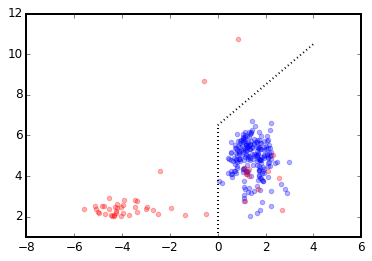

In [6]:
mpld3.enable_notebook()
def plot_Gl(df, good, alpha=0.3):
    x = 'ln_G_50'
    y = 'ln_l_50'
    bad = ~good
    plt.scatter(df[good][x], df[good][y], color='b', alpha=alpha)
    plt.scatter(df[bad][x], df[bad][y], color='r', alpha=alpha);
    x = np.linspace(Glim, 4, 100)
    y = x + y_int
    plt.plot(x, y, 'k:')
    plt.plot([Glim, Glim], [0, y_int-Glim], 'k:')
    plt.ylim(ymin=1)
    
good = good_mask(subdf, has_truth=False, max_unc=0.5)
bad = ~good
print('{} classified as good; {} bad.'.format(good.sum(), bad.sum()))
plot_Gl(subdf, good);


OK, great; looks like there is a pretty distinct "good" clump that we can delineate *just using the inferred hyperparameters, without using any information about the McQ+ ACF measurement*.

Let's see what happens when we look at the comparison plot with just these that we mark "good".

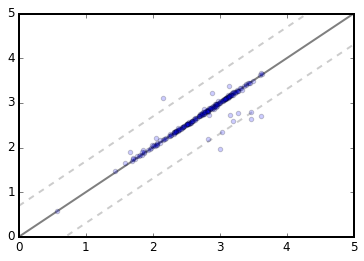

In [7]:
scatter_compare(subdf[good]);

OK, this is awesome. The ones that are "off" are "off" by a factor of two or so, which could be our mistake or McQ's, in principle.  Would be interesting to check out some of those cases.

This demonstrates that we can look at the ensemble results on the hyperparameters, do a by-eye clustering in $l-G$ space, and accurately identify fits that are "good" based on this clustering and by requiring the uncertainties be small(ish).

This means that we can now un-tie ourselves from the McQ results and look to see how many rotation periods we can infer from the total sample of ~1000 (when McQ+ had identified 266):

In [8]:
good_all = good_mask(df, has_truth=False, max_unc=0.3)
good_all.sum()

635

This is how the clustering looks now:

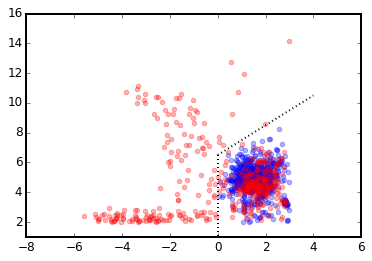

In [9]:
plot_Gl(df, good_all);

So this is awesome--- we get 2.5x more rotation periods in this particular sample from our inference than McQ+, and with uncertainties.

However, this isn't totally fair because probably not all of these KOIs were in the overall target list for McQ.  So let's see how many of our detections really went undetected in McQ+13.

436 good Prots identified out of 746.  McQ got 266


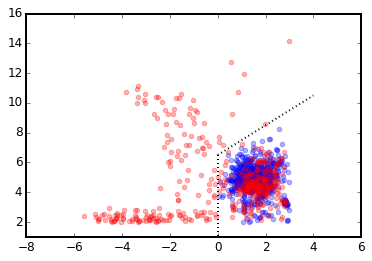

In [10]:
df_sample = df.join(mcq_df, how='inner')
good_sample = good_mask(df_sample, has_truth=False, max_unc=0.3)
n_mcq = len(df_sample.dropna())
print('{} good Prots identified out of {}.  McQ got {}'.format(good_sample.sum(),
                                                              len(df_sample),
                                                              n_mcq))
plot_Gl(df, good_all);

So the final accounting is that this method finds more than 60% more rotation periods than the ACF method, *and* returns uncertainties.  Boom.